# Client Churning Predictor

In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import AdaBoostClassifier
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from math import ceil
from pickle import dump

## Data fetching
data available at <https://www.kaggle.com/datasets/surajbhandari527/ecommerce-churn-data-for-churn-prediction-models?resource=download>

In [169]:
data_path = Path.cwd().parent/'data'/'ecommerce_churn_data.csv'
raw_df = pd.read_csv(data_path)

## Data Overview

In [170]:
raw_df

,CustomerID,Age,Gender,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,HoursSpentOnApp,NumberOfDevicesRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderCount,DaySinceLastOrder,CashbackAmount,Churn
0,56346,29,Male,5.0,Desktop,1,7.2,2.5,2,3,1,1,8,15,45.20,1
1,56347,45,Female,36.0,Mobile,3,20.1,4.8,4,5,3,0,50,2,320.50,0
2,56348,22,Male,2.0,Mobile,1,5.0,1.8,1,2,1,1,3,25,10.10,1
3,56349,39,Female,24.0,Desktop,2,15.3,3.9,3,4,2,0,35,5,210.90,0
4,56350,31,Male,12.0,Mobile,1,8.8,3.0,2,3,1,0,18,10,80.40,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10200,9946,32,Female,25.0,Mobile,2,8.0,4.1,3,4,1,0,27,7,240.00,0
10201,9947,26,Male,9.0,Mobile,3,4.7,3.3,1,3,1,0,9,15,105.75,0
10202,9948,42,Female,35.0,Desktop,1,11.5,4.5,4,5,3,0,30,4,270.00,0
10203,9949,31,Male,16.0,Mobile,2,6.0,3.5,2,3,2,1,18,11,160.50,1


In [171]:
raw_df.describe()

,CustomerID,Age,Tenure,CityTier,WarehouseToHome,HoursSpentOnApp,NumberOfDevicesRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderCount,DaySinceLastOrder,CashbackAmount,Churn
count,10205.000000,10205.000000,10204.000000,10205.000000,10205.000000,10205.000000,10205.000000,10205.000000,10205.000000,10205.000000,10205.000000,10205.000000,10205.000000,10205.000000
mean,29677.581872,35.193043,19.685515,2.007349,9.887428,3.343626,2.833807,3.504459,1.861832,0.216267,21.453895,8.891720,157.953214,0.238707
std,25617.824693,9.625432,14.475853,0.826741,5.481747,1.133353,0.921249,1.162892,0.920454,0.411718,18.955878,8.283807,107.627670,0.426314
min,307.000000,18.000000,1.000000,1.000000,0.500000,0.800000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5097.000000,28.000000,8.000000,1.000000,6.000000,2.500000,2.000000,3.000000,1.000000,0.000000,9.000000,3.000000,75.000000,0.000000
50%,9711.000000,33.000000,16.000000,2.000000,9.000000,3.400000,3.000000,4.000000,2.000000,0.000000,18.000000,6.000000,140.000000,0.000000
75%,56429.000000,42.000000,28.000000,3.000000,13.000000,4.100000,3.000000,4.000000,2.000000,0.000000,28.000000,12.000000,220.000000,0.000000
max,56760.000000,65.000000,85.000000,3.000000,35.000000,8.500000,5.000000,5.000000,5.000000,1.000000,250.000000,60.000000,1120.000000,1.000000


In [172]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10205 entries, 0 to 10204
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 10205 non-null  int64  
 1   Age                        10205 non-null  int64  
 2   Gender                     10205 non-null  object 
 3   Tenure                     10204 non-null  float64
 4   PreferredLoginDevice       10205 non-null  object 
 5   CityTier                   10205 non-null  int64  
 6   WarehouseToHome            10205 non-null  float64
 7   HoursSpentOnApp            10205 non-null  float64
 8   NumberOfDevicesRegistered  10205 non-null  int64  
 9   SatisfactionScore          10205 non-null  int64  
 10  NumberOfAddress            10205 non-null  int64  
 11  Complain                   10205 non-null  int64  
 12  OrderCount                 10205 non-null  int64  
 13  DaySinceLastOrder          10205 non-null  int

In [173]:
n_null = (~raw_df.notna()).sum()
print(f'null values:\n{n_null}')

null values:
CustomerID                   0
Age                          0
Gender                       0
Tenure                       1
PreferredLoginDevice         0
CityTier                     0
WarehouseToHome              0
HoursSpentOnApp              0
NumberOfDevicesRegistered    0
SatisfactionScore            0
NumberOfAddress              0
Complain                     0
OrderCount                   0
DaySinceLastOrder            0
CashbackAmount               0
Churn                        0
dtype: int64


In [174]:
raw_df.Gender.value_counts()

Gender
Male      5145
Female    5058
Other        2
Name: count, dtype: int64

In [175]:
raw_df.PreferredLoginDevice.value_counts()

PreferredLoginDevice
Mobile     6509
Desktop    3696
Name: count, dtype: int64

In [176]:
n_duplicated = raw_df.duplicated().sum()
print(f'The data has {n_duplicated} duplicates')

The data has 0 duplicates


### Data overview analysis
- The dataset is pretty clean.
- Only one missing value in the `Tenure` column.
- This is an imbalanced dataset with only 0.24% of the clients churning.
- Almost all the variables are numerical, except for a few categorical (`Gender` and `PreferredLoginDevice`)

### Initial data cleaning
There is a bit of polishing we can do before starting the analysis.

In [177]:
df = raw_df.copy()
df.drop(['CustomerID'], axis=1, inplace=True)
df.fillna(df.Tenure.mean(), inplace=True)

## Multivariate and univariate analysis

### Figure 1.

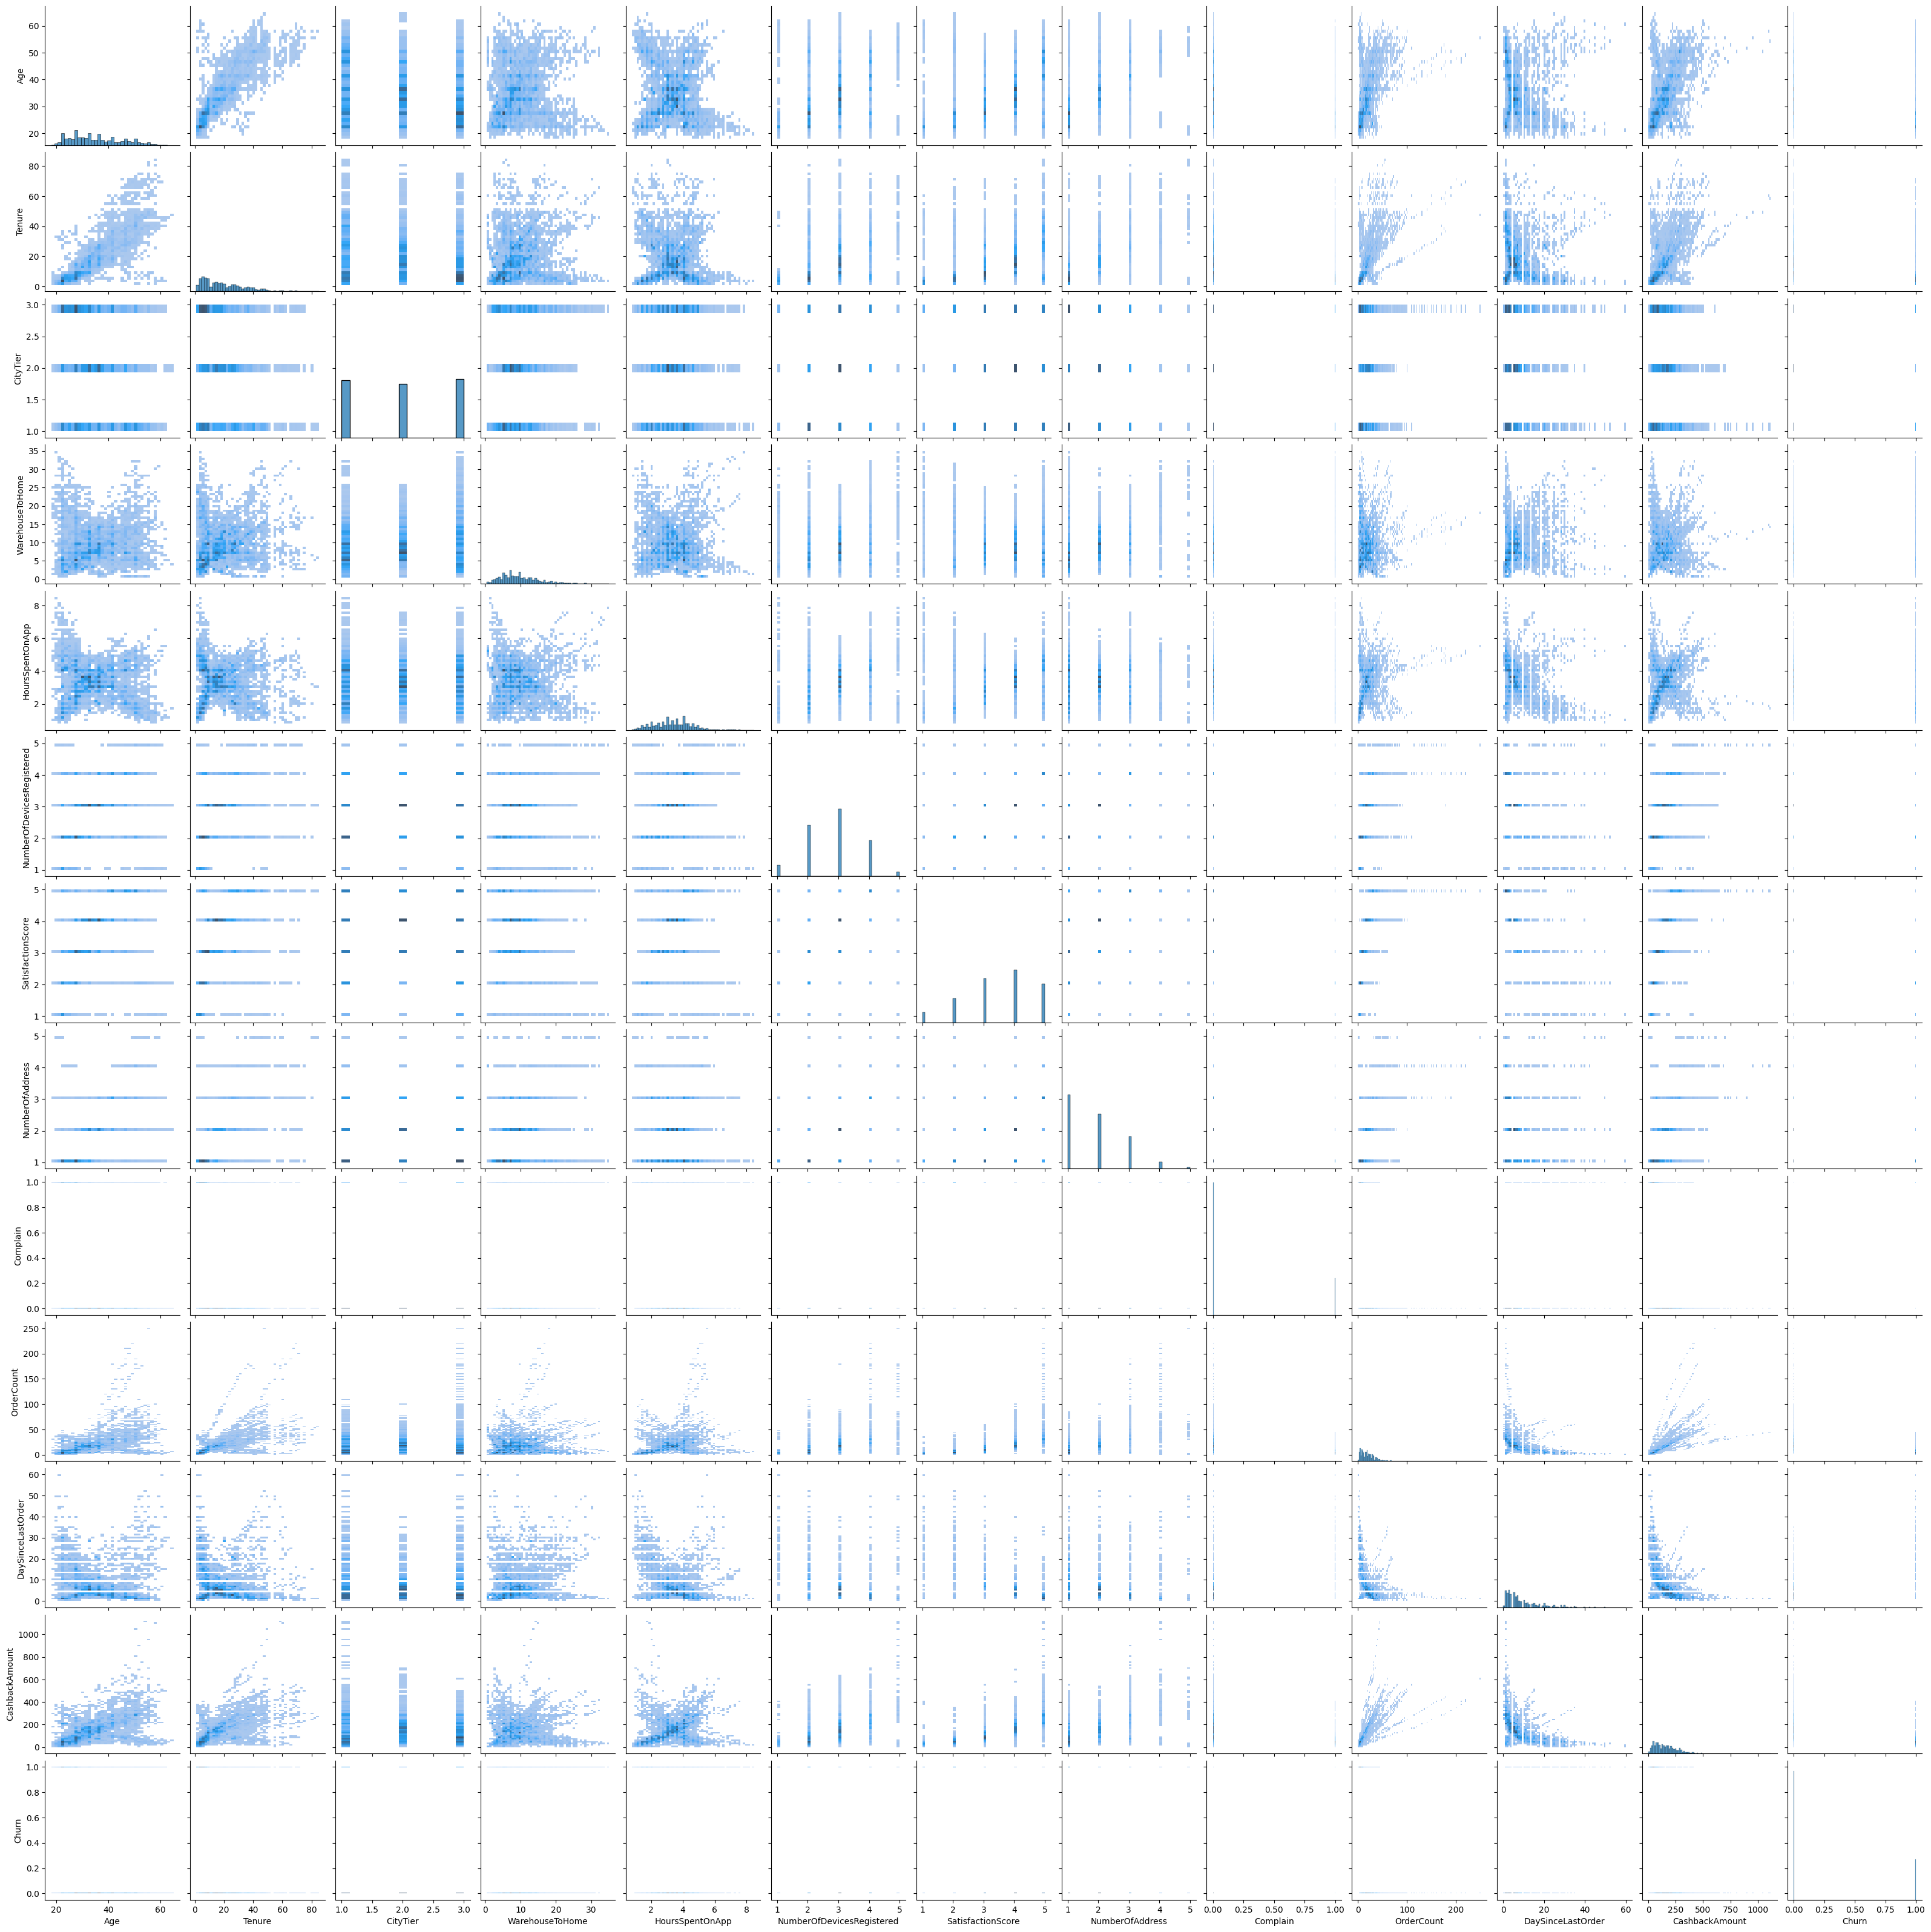

In [199]:
sns.pairplot(df, kind='hist')
plt.show()

### Figure 2.

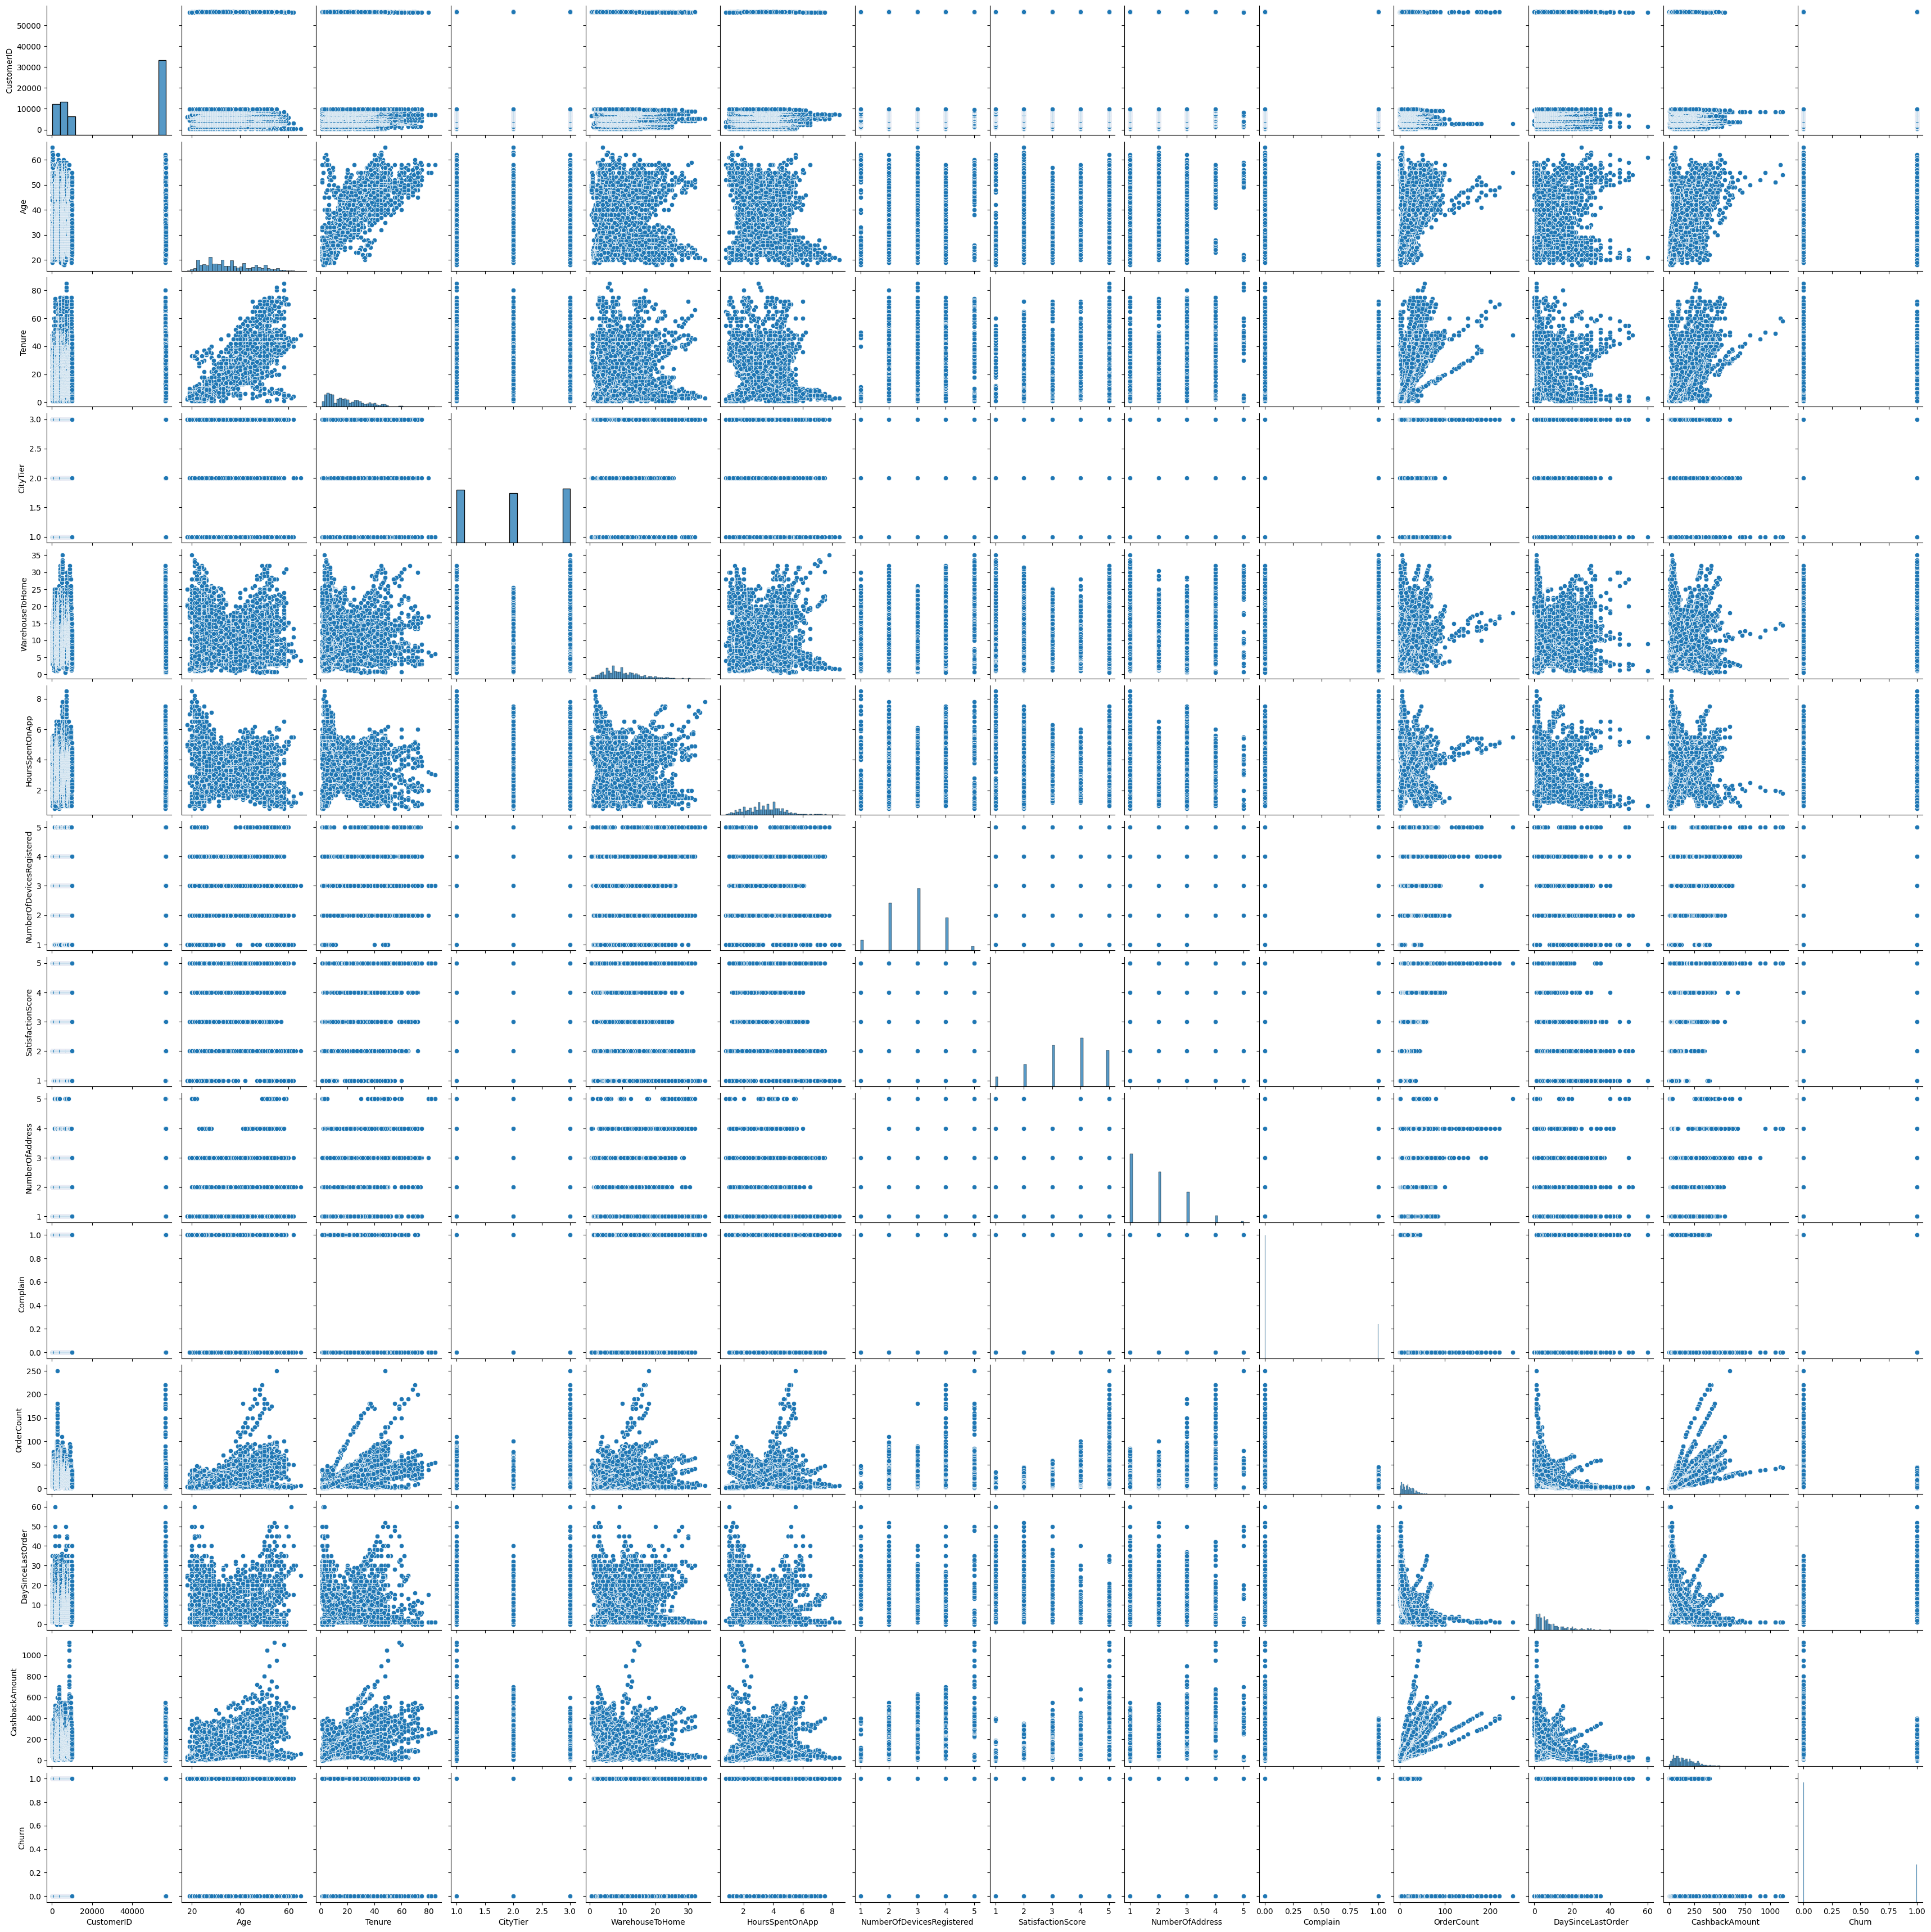

In [178]:
sns.pairplot(raw_df)
plt.show()

### Figure 3

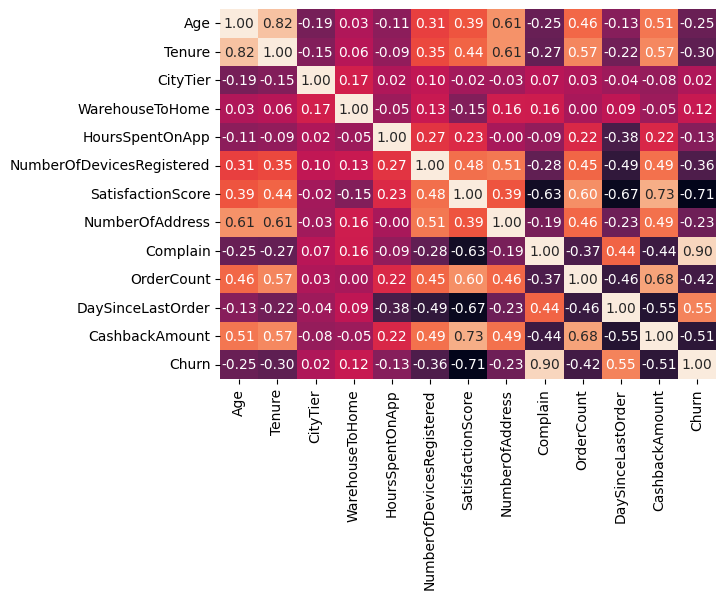

In [202]:
sns.heatmap(
    df.drop(columns=['Gender','PreferredLoginDevice']).corr(),
    annot=True,
    fmt='.2f',
    cbar=False
)
plt.show()

### Figure 4

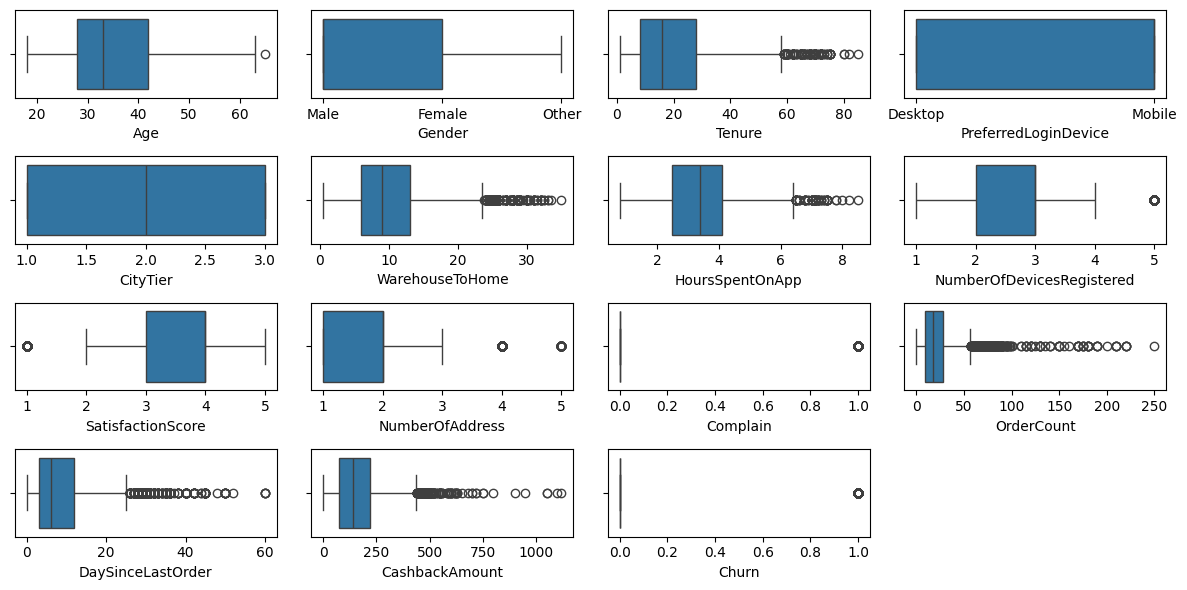

In [204]:
nplots = len(df.columns)

ncols = 4
nrows = ceil(nplots/ncols)
sizein = 3

fig = plt.figure(figsize=(sizein*ncols, sizein*nrows*0.5))
ax=[]

for i, col in enumerate(df.columns):
    new_plot = fig.add_subplot(nrows, ncols, i+1)
    ax.append(new_plot)
    
    sns.boxplot(df, x=col, ax=ax[i])
    
plt.tight_layout()
plt.show()

### EDA conclusions

- There is a high correlation between `Tenure` and `Age` but not high enough to get rid of one of them. (fig 3)
- There is a high correlation between `Churn` and `Complain` but since `Churn` is our target variable, we can't get rid of it. (fig 3)
- In fig 4 we can see that there are not outstanding outliers. (`Complain` and `Churn` are imbalanced columns so the the boxplot looks like there are outliers but there are not)
- Fig 2 shows that the relationships between the features of this dataset are very disperse, so we will need a robust model to make good predictions.

## Model Creation

- For the reasons above I choose to go with a boost classifier, more specifically `AdaBoost` given that it is a model that centers on learning about the datapoints that are difficult to classify.
- Since we are dealing with an unbalanced dataset the metring we will use for the model is the f1 score.

### Pre-processing

- Since this model will later be used to deploy a web app, It will come in handy to create a pre-processing pipeline.
- The only variables that need pre-processing are the categorical. I choose a one-hot-encoding for gender since it can be Male, Female or Other. For the device, since it is binary I used an ordinal encoding.
- For the numerical features there is no pre-processing needed because we are using a tre-based model.
- For the validation set I used a random sample as big as the 20% of our original dataset. 


In [205]:
x = df.drop('Churn',axis=1)
y = df.Churn
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('gender_encoder', OneHotEncoder(handle_unknown='ignore'), ['Gender']),
        ('device_encoder', OrdinalEncoder(), ['PreferredLoginDevice'])
    ],
    remainder='passthrough'
)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', AdaBoostClassifier(random_state=42))
    ]
)

f1 score: 0.9742002063983488


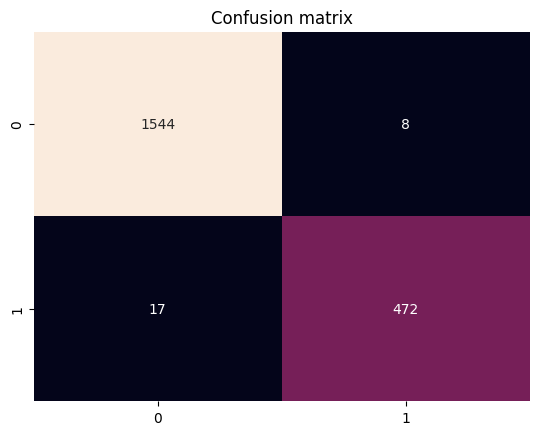

In [ ]:
pipeline.fit(xtrain, ytrain)
ypred = pipeline.predict(xtest)

results = (ytest, ypred)
conf_matr = metrics.confusion_matrix(*results)
print(f'f1 score: {metrics.f1_score(*results):}')

plt.title('Confusion matrix')
sns.heatmap(conf_matr, annot=True, cbar=False, fmt='')
plt.show()

f1 score: 0.9877300613496932


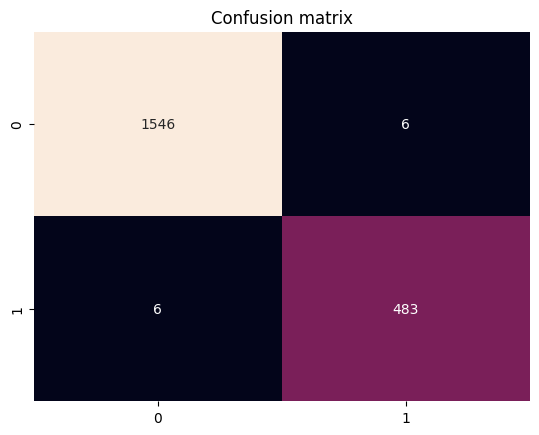

In [207]:
params = {
    'classifier__n_estimators':[100, 200, 300],
    'classifier__learning_rate':[0.01,1,1.25,1.5,1.75,1.875,],
    }
grid = GridSearchCV(pipeline, param_grid=params, scoring='f1', n_jobs=-1)
grid.fit(xtrain, ytrain)
best_model = grid.best_estimator_

ypred = best_model.predict(xtest)

results = (ytest, ypred)
conf_matr = metrics.confusion_matrix(*results)
print(f'f1 score: {metrics.f1_score(*results)}')
plt.title('Confusion matrix')
sns.heatmap(conf_matr, annot=True, cbar=False, fmt='')
plt.show()

In [182]:
best_model

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('gender_encoder', ...), ('device_encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Model conclusions

Our pipeline ended up being really useful for the application deployment, since it made us able to just pass raw data to the model. Also, our model Is incredibly good, there is a chance that this means that AdaBoos was probably the right choice, but the most likely reasons for this are the next:
- The data is really clean.
- The data was artificially created. 
Particularly, this last reason is a strong candidate since in fact this data is artificial (check the source of the data for more info on this), and depending on the method used to create the data, this might influence how easy it is to create predictive models with it.

You can play with the model at <https://client-churning-predictor.onrender.com/>, where the application was deployed.


In [183]:
model_name = 'AdaBoost_learning_rate_1.5_n_estimators_300_random_state_42.sav'
with open('../models/'+model_name,'wb') as f:
    dump(best_model, f)